In [1]:
import gpt_2_simple as gpt2
import os
import requests
import zipfile
import numpy as np
import re
import matplotlib.pyplot as plt
import difflib
from IPython.display import Markdown, display
def printmd(string, add=""):
    display(Markdown(string + " " + str(add)))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

# Signal

In [4]:
# classification task
signal = "ipo"

# Processing Data 

In [5]:
# path to data of classification task
path = signal + "/"

In [6]:
def get_zipped_dataset(name, labels=False, titles=True, exclude=".json"):
    def get_dataset_class(filename):
        splittet_name = filename.split(".")
        if len(splittet_name) > 1 and splittet_name[1].replace("U", "") == str(1):
            return 1
        else: return 0

    dataset, dataset_titles, filenames = [], [], []
    dataset_pos, dataset_neg, dataset_pos_titles, dataset_neg_titles = [], [], [], []

    with zipfile.ZipFile(path + "data.zip") as z:
        for filename in z.namelist():
            if name in filename and ".txt" in filename and not exclude in filename:
                with z.open(filename) as f:
                    # getting whole text
                    full_text = f.read().decode('utf-8')
                    # getting only titles
                    title = re.search('xxtitle (.*) xxbodytext', full_text).group(1)
                    
                    filenames.append(filename)
                    
                    if labels:
                        if get_dataset_class(filename):
                            dataset_pos.append(full_text)
                            dataset_pos_titles.append(title)
                        else:
                            dataset_neg.append(full_text)
                            dataset_neg_titles.append(title)
                    else:
                        dataset.append(full_text)
                        dataset_titles.append(title)
    if labels:
        return dataset_pos, dataset_pos_titles, dataset_neg, dataset_neg_titles
    else:
        return dataset, dataset_titles, filenames
    

#unlabeled_data, unlabeled_data_titles, unlabeled_filenames = get_zipped_dataset("randomsig_wt/", exclude="small")

#test_data, test_data_titles, test_filenames = get_zipped_dataset("test/")
##unlabeled_data.extend(test_data)
##unlabeled_data_titles.extend(test_data_titles)

positive_data, positive_data_titles, negative_data, negative_data_titles = get_zipped_dataset("train", labels=True)

                
print("Size of labeled data:", len(positive_data) + len(negative_data))
print("Size of positive data:", len(positive_data))
print("Size of negative data:", len(negative_data))
#print("Size of unlabeled data:", len(unlabeled_data))

Size of labeled data: 1655
Size of positive data: 561
Size of negative data: 1094


In [7]:
training_size = 100

In [ ]:
positive_data_titles[0]

In [ ]:
positive_data[0]

## Writing the positive Data into one file seperated with special tokens

In [10]:
prefix = "<|startoftext|> "
suffix = " <|endoftext|>"

file_name = path + "data/aug_textgen/finetuning.txt"
file = open(file_name, "w")
for text in positive_data:
    file.write(prefix)
    file.write(text)
    file.write(suffix)
    file.write("\n\n")
file.close()

# Loading and fintuning GPT-2

In [10]:
model_name = "355M"

if not os.path.isdir(os.path.join("models", model_name)):
    print(f"Downloading {model_name} model...")
    gpt2.download_gpt2(model_name=model_name)   # model is saved into current directory under /models/335M/
    
sess = gpt2.start_tf_sess()

In [ ]:
file_name = path + "data/aug_textgen/finetuning.txt"
gpt2.finetune(sess,
              file_name,
              model_name=model_name,
              run_name='run' + signal.capitalize(),
              sample_every=1000,
              steps=1)   

# Generate and select the new training data

## Using GPT-2 to generate 10 new texts for each positive title

In [ ]:
for index, title in enumerate(positive_data_titles):
    if index <= 379:
        continue
    prefix_gen = "<|startoftext|> xxtitle " + title + " xxbodytext"
    gpt2.generate(sess, 
                model_name=model_name, 
                prefix=prefix_gen, 
                truncate="<|endoftext|>", 
                include_prefix=True, 
                destination_path="generated_samples/" + signal + "/temperature_07_" + str(index) + ".txt",
                temperature=0.7,
                nsamples=10)
    
    print(str(index + 1) + "/" + str(len(positive_data_titles)))

In [ ]:
gpt2.reset_session(sess)

## Reading the saved data

In [8]:
index = 0
new_data = []
while(os.path.isfile("generated_samples/" + signal + "/temperature_07_" + str(index) + ".txt")):
    file_name = "generated_samples/" + signal + "/temperature_07_" + str(index) + ".txt"
    with open(file_name) as file:
        texts = file.read()
        temp_data = texts.split("\n====================\n<|startoftext|> ")
        temp_data[0] = temp_data[0].replace("<|startoftext|> ", "")
    new_data.extend(temp_data)
    index += 1

In [ ]:
len(new_data)

## Filtering the data 

In [10]:
from sentence_transformers import SentenceTransformer, models
model = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')

In [11]:
positive_data_embeddings = model.encode(np.array(positive_data))

In [12]:
generated_data_embeddings = model.encode(np.array(new_data))

In [ ]:
def get_centroid(embeddings):
    embedding_sum = np.sum(embeddings, axis=0)
    return np.divide(embedding_sum, len(embeddings[0]))

positive_data_centroid = get_centroid(positive_data_embeddings)
print(positive_data_centroid)

Remember: cosine similarity is 1 if the vectors have the same angle (same similarity) and 0 if the vectors are unsimilar
 

**[Labeled Data]** The vector that is **least similar** to the other vectors has a similarity score of 0.2761887

**[Labeled Data]** The article of it is: xxtitle The Latest: Last Australian prime minister to quit this week xxbodytext The Latest on Australian politics (all times local):

11:50 p.m.

Australia's former prime minister says he will resign from Parliament this week in a move that could cost the unpopular conservative government its single-seat majority.

Malcolm Turnbull told supporters that he will resign from Parliament on Friday, a week after he was forced from office by lawmakers in his conservative Liberal Party because he had lost their support.

That could set the stage for an Oct. 6 by-election. Prime Minister Scott Morrison could also call general elections, although he has said he plans to hold polls close to when an election is due in May.

Morrison visited the drought-stricken Outback on Monday in a demonstration that he has turned his focus away from his government's internal drama to the problems of the nation.

3:30 p.m.

Australia's new prime minister has visited the drought-stricken Outback as he turns his focus away from his government's internal drama.

Prime Minister Scott Morrison selected drought assistance as a top priority along with national security and economic growth when he was chosen by lawmakers in his conservative Liberal Party on Friday.

His predecessor, Malcolm Turnbull, became the fourth prime minister dumped by his or her own party since 2010 in response to poor opinion polling.

Morrison flew Monday to rural western Queensland state, where crops are failing and ranchers are struggling to feed sheep and cattle after six years of drought. He has not yet announced any new initiatives to help farmers.

**[Labeled Data]** Boxplot: Distances of the positive set to the positive centroid 

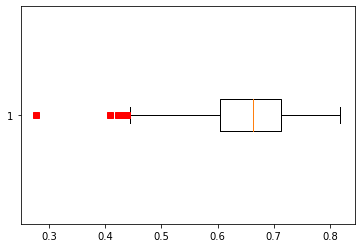

<br>**[Generated Data]** The vector that is **most similar** to the other vectors has a similarity score of 0.8280262

**[Generated Data]** The article of it is: xxtitle Salvadoran farmers lament brutal drought, hope for recovery xxbodytext Encouraged by a good harvest last year, Salvadoran farmers turned their hopes to the rain this year. But with heavy rains in some areas since November, farmers have not been able to harvest anything from the more than 3 million hectares they had.

“It was a difficult year. Many farmers had lost crops and were only able to harvest about 2.5 million tonnes from our farms,” said Salvadoran economist Ildefonso Ortiz.

Of the more than 3 million hectares of crops that the country had in 2018, about 2.5 million hectares had been harvested by the end of March, according to the National Assembly.

That figure includes 1.5 million hectares of corn that had been harvested in Ometepe, a poor region in which to grow crops because of extremely hot weather. Ometepe is the country’s main corn producer.

As the drought has continued, so has the infestation of the Asian brown marmorated stink bug, a threat to soy and other crops that will greatly affect the country’s food production next year.

The government has intensified its control over the pest, issuing alerts when an adult is spotted in a crop field. It also uses drones to kill the insects.

The government estimated in September that it had destroyed more than 20,000 hectares of hardwoods in the country’s soybean and corn sectors.

Although the pest was initially on the decline in South America, authorities have said they fear it could return to normal levels due to climate change.

In the worst-case scenario, if the climate changes again, Ortiz said, “we could lose the ability to harvest, plus the inability to plant, plus the inability to harvest later because of the lack of moisture in the fields.”

Brown marmorated stink bugs are native to tropical and subtropical parts of the Americas, and are distributed widely in both hemispheres. They are sexually dimorphic — females are bigger and more numerous than males — and breed in clusters of two to six generations. A female can lay up to eight eggs in one generation. A brown marmorated stink bug is lithe and smaller than a typical brown marmorated stink bug, though it may weigh as much as 30 kilograms. It may also sting more than a typical black marmorated stink bug.

The pest has been reported in more than 80 countries in South America, the most recent of which is in January. Government agencies and nongovernmental organizations worldwide are urged to monitor the pest for the first time. 

**[Generated Data]** The vector that is **least similar** to the other vectors has a similarity score of 0.20007469

**[Generated Data]** The article of it is: xxtitle UW summarizes Washington climate impact on water xxbodytext The following is adapted from a report prepared by the Water Climate Center’s Climate Impacts Group at the University of Wisconsin–Madison. 

**[Generated Data]** Boxplot: Distances of the unlabeled set to the positive centroid 

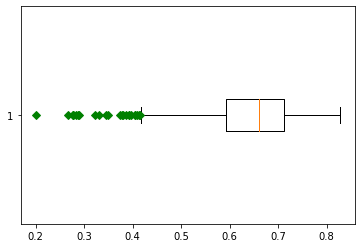

In [14]:
def get_distances(embeddings, centroid, cosine=True):
    def cosine_similarity(a,b):
        return np.dot(a,b)/(np.linalg.norm(a) * np.linalg.norm(b))
    
    if cosine:
        return [cosine_similarity(embedding, centroid) for embedding in embeddings]
    else:
        return - [np.linalg.norm(centroid-embedding, 2) for embedding in embeddings]
    
generated_data_distances = get_distances(generated_data_embeddings, positive_data_centroid)
positive_data_distances = get_distances(positive_data_embeddings, positive_data_centroid)

printmd("Remember: cosine similarity is 1 if the vectors have the same angle (same similarity) and 0 if the vectors are unsimilar\n")

printmd("**[Labeled Data]** The vector that is **least similar** to the other vectors has a similarity score of", np.min(positive_data_distances))
printmd("**[Labeled Data]** The article of it is:", positive_data[np.argmin(positive_data_distances)])
printmd("**[Labeled Data]** Boxplot: Distances of the positive set to the positive centroid")
fig, ax = plt.subplots()
ax.boxplot(positive_data_distances, 0, 'rs', 0)
plt.show()

printmd("<br>**[Generated Data]** The vector that is **most similar** to the other vectors has a similarity score of", np.max(generated_data_distances))
printmd("**[Generated Data]** The article of it is:", new_data[np.argmax(generated_data_distances)])

printmd("**[Generated Data]** The vector that is **least similar** to the other vectors has a similarity score of", np.min(generated_data_distances))
printmd("**[Generated Data]** The article of it is:", new_data[np.argmin(generated_data_distances)])

printmd("**[Generated Data]** Boxplot: Distances of the unlabeled set to the positive centroid")
fig, ax = plt.subplots()
ax.boxplot(generated_data_distances, 0, 'gD', 0)
plt.show()

In [15]:
def get_k_nearest_indices(distances, k, inverse=False):
    distances = np.array(distances)
    if not inverse:
        return np.argsort(distances)[::-1][:k]
    else:
        return np.argsort(distances)[:k]

def get_nearest_indices_threshold(distances, threshold, inverse=False):
    if not inverse:
        distances = np.array(distances)
        threshold_count = len(list(filter(lambda x: x > threshold, distances)))
        return np.argsort(distances)[::-1][:threshold_count]
    else:
        distances = np.array(distances)
        threshold_count = len(list(filter(lambda x: x < threshold, distances)))
        return np.argsort(distances)[:threshold_count]
    
    
#index_of_nearest_dataset = get_k_nearest_indices(unlabeled_distances, 1000)
lower_quantile = np.quantile(positive_data_distances, 0.15) 
index_of_nearest_dataset = get_nearest_indices_threshold(generated_data_distances, lower_quantile)
len(index_of_nearest_dataset)

722

In [17]:
generated_positive_dataset = [new_data[index] for index in index_of_nearest_dataset]

It may be sensible to look into the least fitting generated example, to adjust the threshold parameter above according to it.

In [ ]:
printmd(generated_positive_dataset[-3])

## Saving the new data set

In [19]:
for index, text in enumerate(generated_positive_dataset):
    file = open(path + "data/aug_textgen_data_07_strict/" + str(index) + "." + "1.txt", "w")
    file.write(text)
    file.close()
